In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl
import ast

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

# IMPORTANDO DADOS

In [477]:
df = pd.read_csv('DataBase.csv')
df

,time,s2,s3,s1
0,58.980,"{'ax': 7611, 'ay': 472, 'wz': 11764, 'az': 869...","{'ax': 7663, 'ay': 503, 'wz': 11772, 'az': 879...","{'ax': 11890, 'ay': 12226, 'wz': 11538, 'az': ..."
1,59.000,"{'ax': 5335, 'ay': 1503, 'wz': 12156, 'az': 10...","{'ax': 5351, 'ay': 1358, 'wz': 11960, 'az': 11...","{'ax': 11906, 'ay': 12210, 'wz': 11538, 'az': ..."
2,59.020,"{'ax': 7646, 'ay': 2458, 'wz': 12284, 'az': 11...","{'ax': 7633, 'ay': 2494, 'wz': 12252, 'az': 11...","{'ax': 11874, 'ay': 12178, 'wz': 11522, 'az': ..."
3,59.040,"{'ax': 1531, 'ay': 1021, 'wz': 11772, 'az': -1...","{'ax': 2042, 'ay': 1007, 'wz': 12216, 'az': -6...","{'ax': 12018, 'ay': 12291, 'wz': 11650, 'az': ..."
4,59.060,"{'ax': 10219, 'ay': 958, 'wz': 12796, 'az': 10...","{'ax': 9966, 'ay': 1007, 'wz': 13308, 'az': 89...","{'ax': 12050, 'ay': 12339, 'wz': 11682, 'az': ..."
...,...,...,...,...
663,73.851,"{'ax': 749, 'ay': 1011, 'wz': 14300, 'az': 153...","{'ax': 762, 'ay': 1006, 'wz': 14324, 'az': 152...","{'ax': 11778, 'ay': 12098, 'wz': 11410, 'az': ..."
664,73.871,"{'ax': -78, 'ay': 399, 'wz': 14268, 'az': 999,...","{'ax': -18, 'ay': 510, 'wz': 14332, 'az': 981,...","{'ax': 11762, 'ay': 12082, 'wz': 11394, 'az': ..."
665,73.891,"{'ax': -49, 'ay': 83, 'wz': 14204, 'az': 463, ...","{'ax': -34, 'ay': 127, 'wz': 14164, 'az': 431,...","{'ax': 11682, 'ay': 12034, 'wz': 11282, 'az': ..."
666,73.911,"{'ax': -3, 'ay': -213, 'wz': 14076, 'az': -145...","{'ax': -3, 'ay': -213, 'wz': 14076, 'az': -129...","{'ax': 11730, 'ay': 12114, 'wz': 11154, 'az': ..."


In [478]:
df = pd.concat([df.time, df.s2.apply(ast.literal_eval).apply(pd.Series)], axis=1)
df

,time,ax,ay,wz,az,wx,wy
0,58.980,7611,472,11764,8695,-7204,-4116
1,59.000,5335,1503,12156,10703,-8212,-3448
2,59.020,7646,2458,12284,11199,-10420,-2084
3,59.040,1531,1021,11772,-17,-2088,-9444
4,59.060,10219,958,12796,10223,-2372,8172
...,...,...,...,...,...,...,...
663,73.851,749,1011,14300,1535,-8212,-4236
664,73.871,-78,399,14268,999,-8844,-4264
665,73.891,-49,83,14204,463,-8324,-4420
666,73.911,-3,-213,14076,-145,-8516,-4100


# NORMALIZANDO DADOS

In [479]:
print(float(np.round(df.time.diff().median(), 3)))
dt = 0.050

0.02


In [480]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,wz,az,wx,wy
0,0.00,7611,472,11764,8695,-7204,-4116
1,0.05,7646,2458,12284,11199,-10420,-2084
2,0.10,10219,958,12796,10223,-2372,8172
3,0.15,4087,-2931,16252,-2,-10168,764
4,0.20,-521,-1033,13756,4050,-7216,-272


# CONVERSÃO DE UNIDADES
Os sensores entregam dados em unidades digitais (LSB), que precisam ser convertidas para m/s² (aceleração) e rad/s (velocidade angular) para fazer cálculos físicos corretos, como integração e rotação.

In [481]:
# Acelerômetro: ±2g → 16384 LSB/g, g = 9.81 m/s²
df['ax'] = (df['ax'] / 16384.0) * 9.81
df['ay'] = (df['ay'] / 16384.0) * 9.81
df['az'] = (df['az'] / 16384.0) * 9.81

# Giroscópio: ±250°/s → 131 LSB/(°/s), converter para rad/s
df['wx'] = (df['wx'] / 131.0) * (np.pi / 180)
df['wy'] = (df['wy'] / 131.0) * (np.pi / 180)
df['wz'] = (df['wz'] / 131.0) * (np.pi / 180)
df.head()

,time,ax,ay,wz,az,wx,wy
0,0.00,4.557123,0.282612,1.567332,5.206174,-0.959798,-0.548380
1,0.05,4.578080,1.471740,1.636613,6.705456,-1.388270,-0.277654
2,0.10,6.118676,0.573607,1.704827,6.121071,-0.316025,1.088766
3,0.15,2.447111,-1.754951,2.165274,-0.001198,-1.354695,0.101789
4,0.20,-0.311951,-0.618514,1.832729,2.424957,-0.961397,-0.036239


# VETORIZAÇÃO

In [482]:
aData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.ax, df.ay, df.az)])
wData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.wx, df.wy, df.wz)])
tData = df.time.to_numpy()
aData[:5]

array([[ 4.55712341e+00,  2.82612305e-01,  5.20617371e+00],
       [ 4.57807983e+00,  1.47173950e+00,  6.70545593e+00],
       [ 6.11867615e+00,  5.73607178e-01,  6.12107117e+00],
       [ 2.44711121e+00, -1.75495056e+00, -1.19750977e-03],
       [-3.11951294e-01, -6.18513794e-01,  2.42495728e+00]])

# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

In [483]:
def plotData(time, data):
    keys, values = list(data.keys()), list(data.values())
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(time, values[0])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[0]}$')
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(time, values[1])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[1]}$')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(time, values[2])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[2]}$')
    plt.grid()

### Aceleração Linear

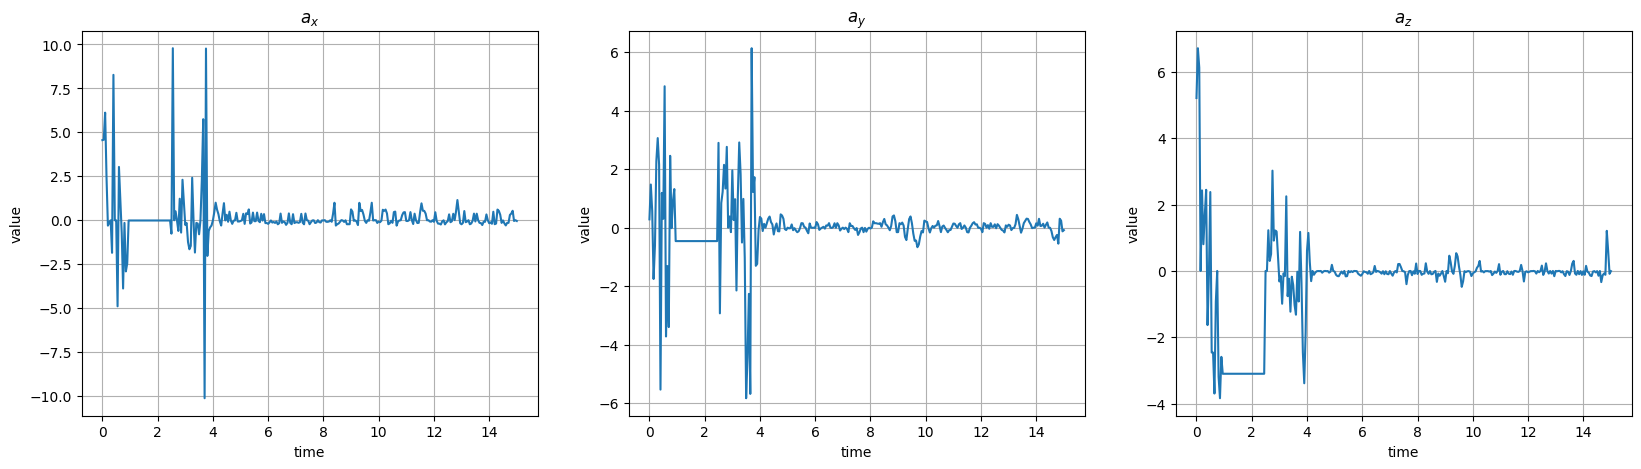

In [484]:
plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
})

- Aplicando Filtro Passa Faixa

TransferFunction(array([282.74333882,   0.        ]), array([1.00000000e+00, 2.82743339e+02, 9.86960440e+03]))

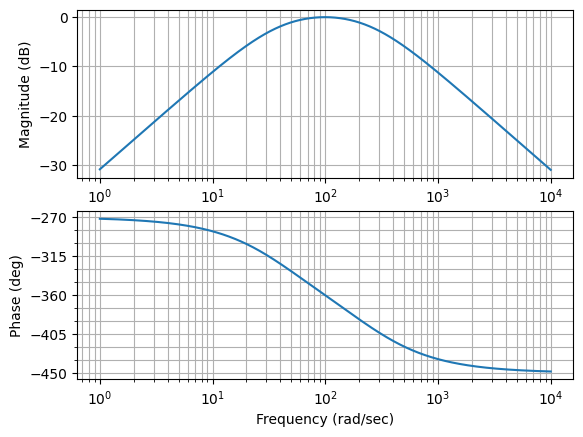

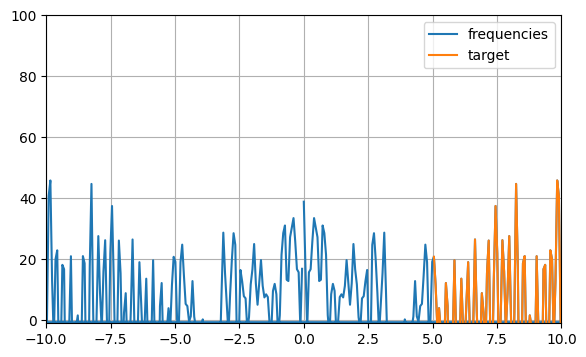

In [485]:
target = (5, 50)
filter = BandFilter(dt, target)
filter.plot()
NumpyFilter().see([ax for (ax, ay, az) in aData], dt, target, range=(-10, 10), yLim=(-1, 100))

In [486]:
print(filter.getOut() + ';')

Xn*(0.496491) + Xn1*(-0.000000) + Xn2*(-0.496491) + Yn1*(-0.726062) + Yn2*(-0.007018);


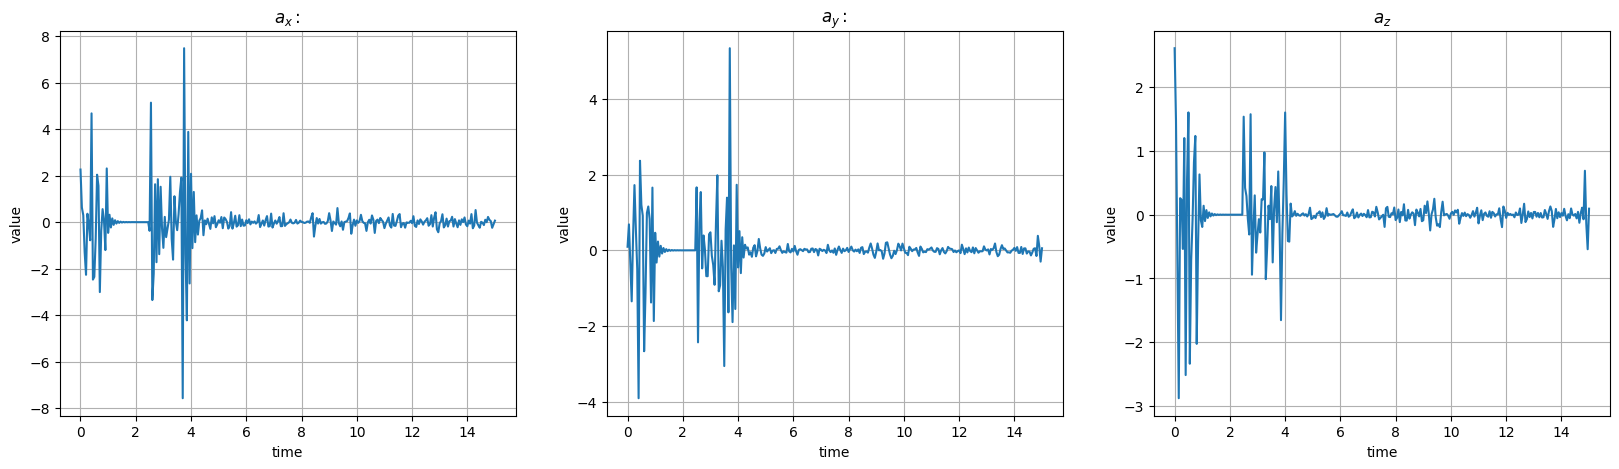

In [487]:
aData = np.column_stack([
    filter.apply([ax for (ax, ay, az) in aData]),
    filter.apply([ay for (ax, ay, az) in aData]),
    filter.apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'a_x: ': [ax for (ax, ay, az) in aData],
    'a_y: ': [ay for (ax, ay, az) in aData],
    'a_z'  : [az for (ax, ay, az) in aData],
})

### Velocidade Linear

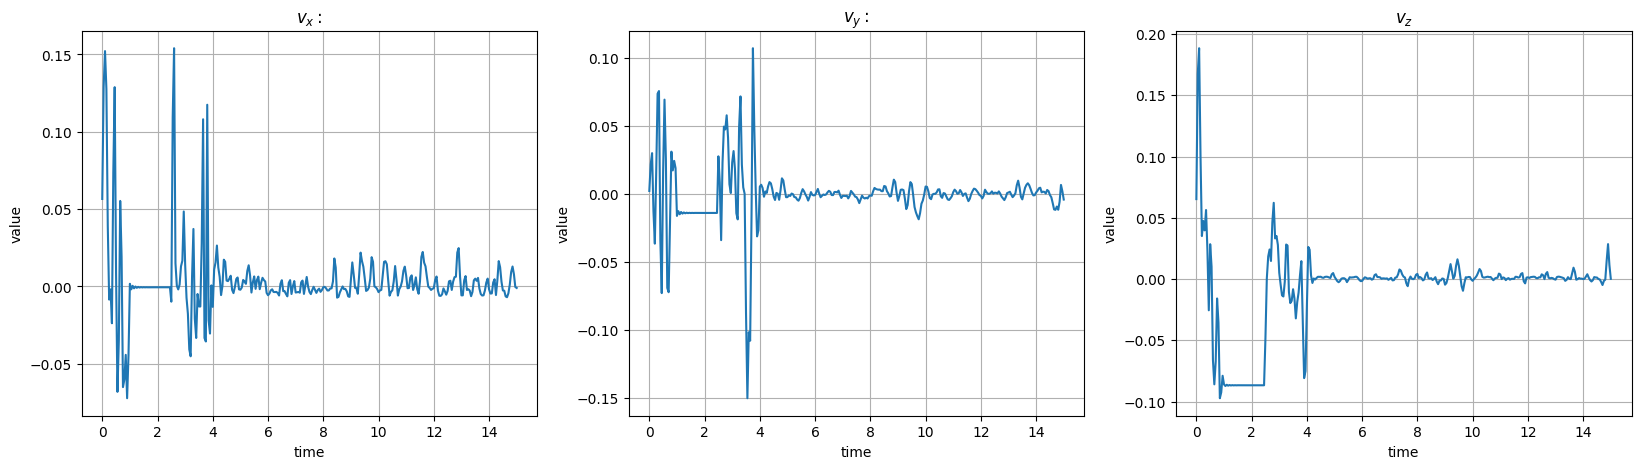

In [488]:
vData = np.column_stack([
    Integral(dt).apply([ax for (ax, ay, az) in aData]),
    Integral(dt).apply([ay for (ax, ay, az) in aData]),
    Integral(dt).apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'v_x: ': [vx for (vx, vy, vz) in vData],
    'v_y: ': [vy for (vx, vy, vz) in vData],
    'v_z'  : [vz for (vx, vy, vz) in vData],
})

### Posição Linear

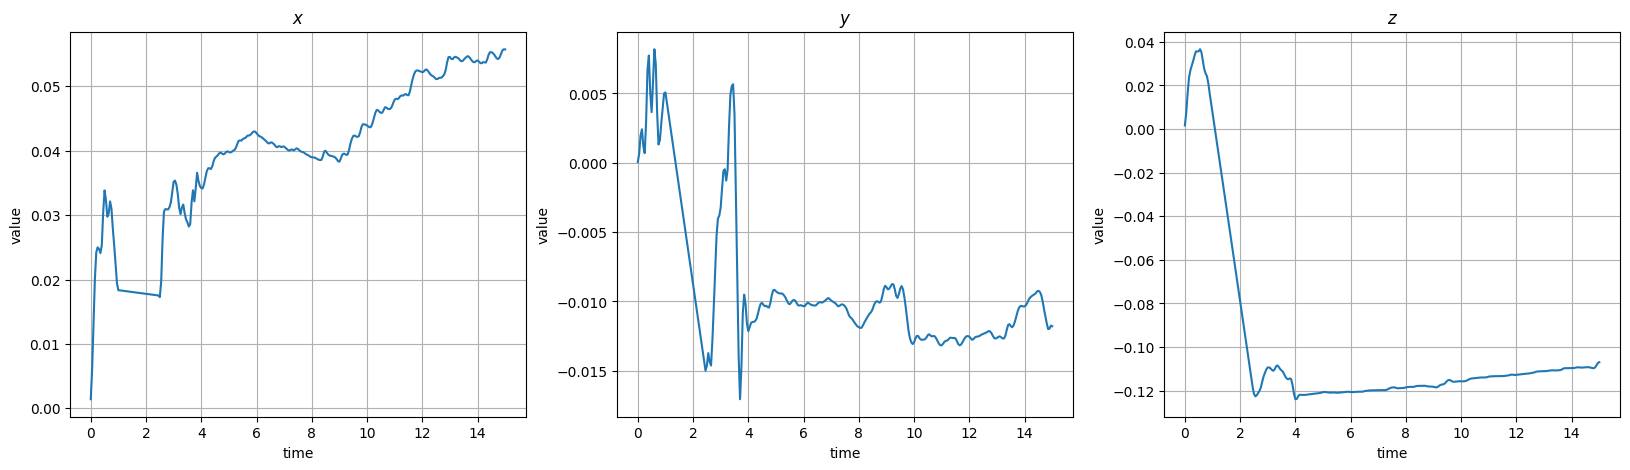

In [489]:
xData = np.column_stack([
    Integral(dt).apply([vx for (vx, vy, vz) in vData]),
    Integral(dt).apply([vy for (vx, vy, vz) in vData]),
    Integral(dt).apply([vz for (vx, vy, vz) in vData])
])

plotData(tData, {
    'x': [x for (x, y, z) in xData],
    'y': [y for (x, y, z) in xData],
    'z': [z for (x, y, z) in xData],
})

TransferFunction(array([39.4784176]), array([ 1.        ,  8.88576588, 39.4784176 ]))

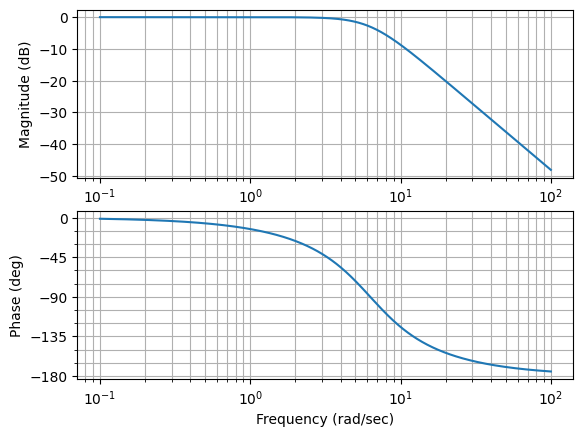

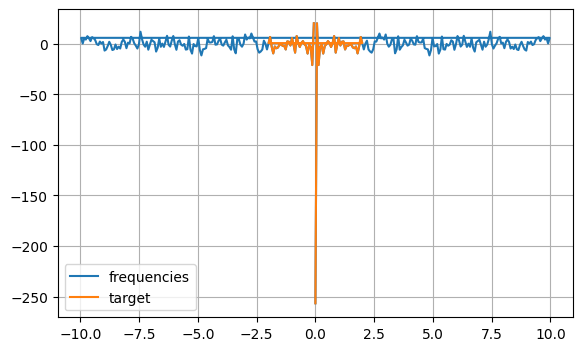

In [490]:
filter = LowBandFilter(f_c=1, dt=dt)
filter.plot()
NumpyFilter().see([wx for (wx, wy, wz) in wData], dt, (-2, 2))

### Angulação

In [491]:
print(filter.getOut() + ';')

Xn*(0.019790) + Xn1*(0.039579) + Xn2*(0.019790) + Yn1*(1.564504) + Yn2*(-0.643662);


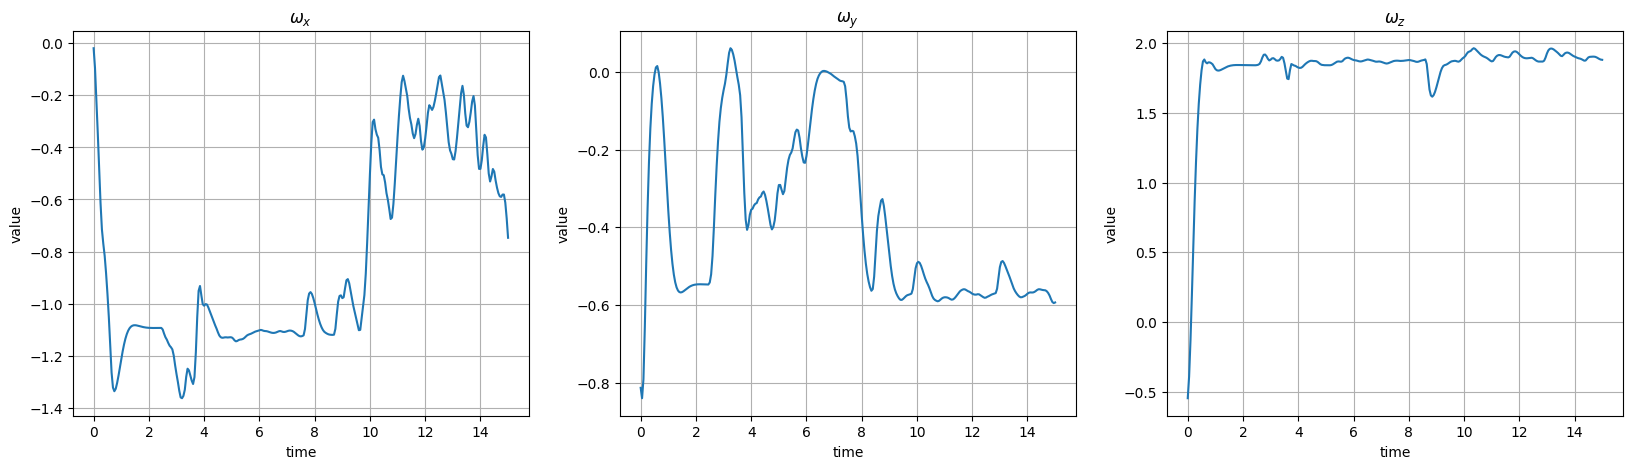

In [492]:
wData = np.column_stack([
    filter.apply([wx for (wx, wy, wz) in wData]),
    filter.apply([wy for (wx, wy, wz) in wData]),
    filter.apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
})

### Ângulo

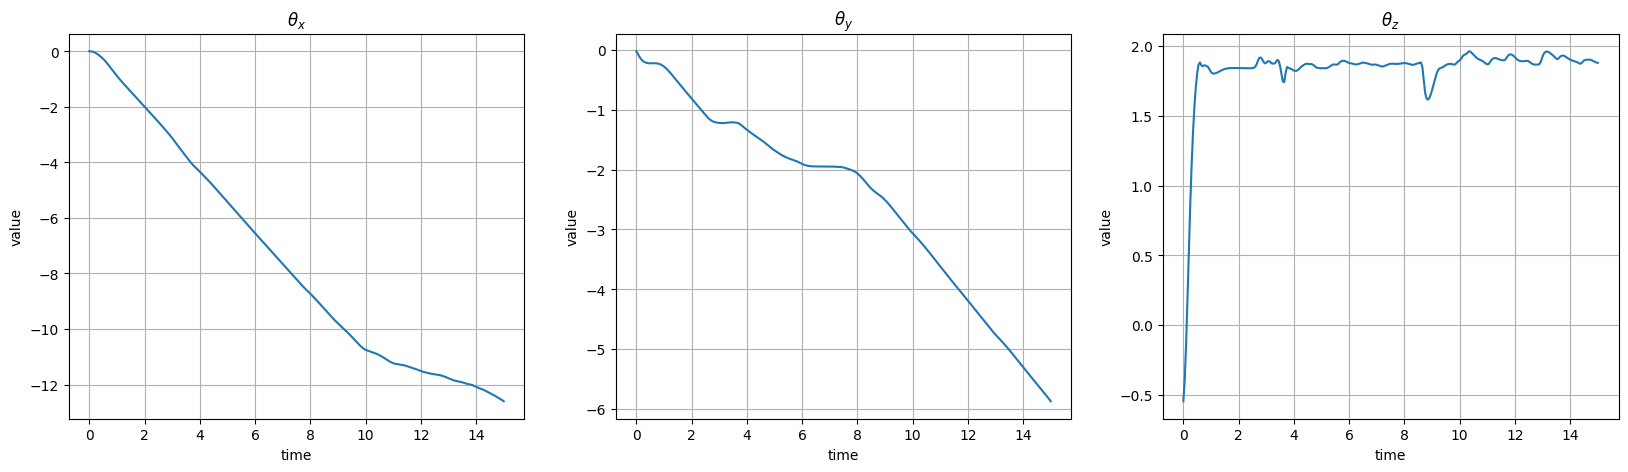

In [493]:
oData = np.column_stack([
    Integral(dt).apply([wx for (wx, wy, wz) in wData]),
    Integral(dt).apply([wy for (wx, wy, wz) in wData]),
    Integral(dt).apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    r'\theta_x': [ox for (ox, oy, oz) in oData],
    r'\theta_y': [oy for (ox, oy, oz) in oData],
    r'\theta_z': [oz for (ox, oy, oz) in wData],
})

### Campo Vetorial

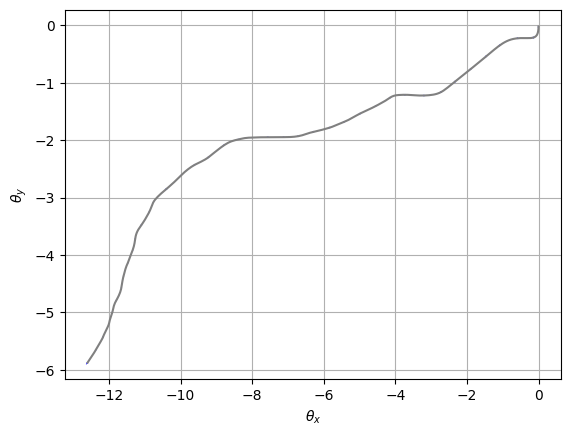

In [494]:
indices = np.linspace(0, len(oData)-1, 40, dtype=int)
x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], color='gray')
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=15, width=0.004, color='blue')
plt.xlabel(r'$\theta_x$'), plt.ylabel(r'$\theta_y$'), plt.grid()
plt.show()

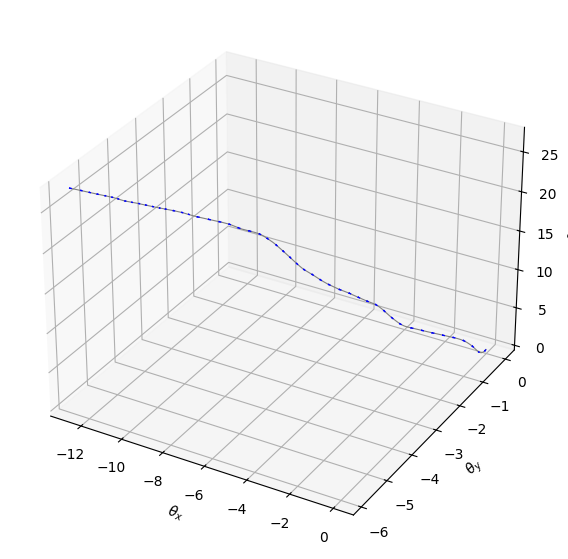

In [495]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(oData)-1, 50, dtype=int)

x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
z = np.array([oz for (ox, oy, oz) in oData])[indices]

u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]
w = np.array([wz for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], [oz for (ox, oy, oz) in oData], lw=0.8, color='gray')
ax.quiver(x, y, z, u, v, w, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel(r'$\theta_x$'), ax.set_ylabel(r'$\theta_y$'), ax.set_zlabel(r'$\theta_z$')
plt.show()

# INFERENCIA
$\theta = \cos^{-1} \left( \frac{\vec{u} \cdot \vec{v}}{\|\vec{u}\| \cdot \|\vec{v}\|} \right)$

In [496]:
ux = np.array([1, 0, 0])
uy = np.array([0, 1, 0])
uz = np.array([0, 0, 1])

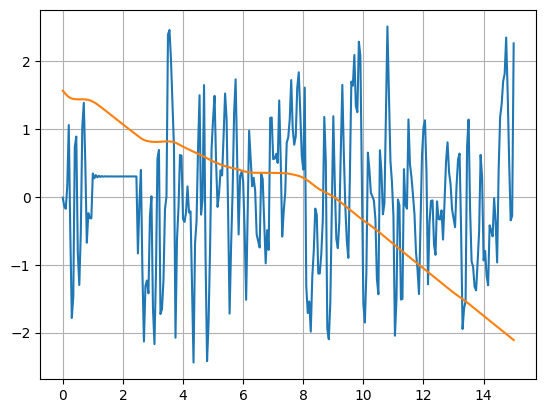

In [497]:
def norm(data):
    mean = np.mean(data)
    std  = np.std(data)
    return [(x - mean)/std for x in data]

def angle(u, v):
    return np.arccos((u @ v)/(np.linalg.norm(u)*np.linalg.norm(v)))

theta_x = [angle(ux, v) for v in vData]
theta_y = [angle(uy, v) for v in vData]
theta_z = [angle(uz, v) for v in vData]

plt.plot(tData, norm(theta_y))
plt.plot(tData, norm([oy for (ox, oy, oz) in oData]))
plt.grid()

# QUARTENION

In [498]:
# Produto de quaternions: q1 ⊗ q2
def quatProduct(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def normalize(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else v

- Quartenions a partir da aceleração

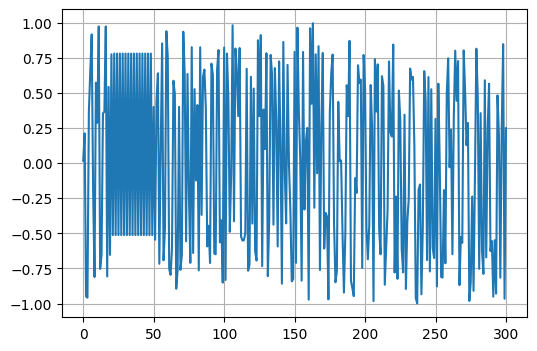

In [499]:
qaData = np.zeros((len(aData), 4))

for i, acc in enumerate(aData):
    ax, ay, az = normalize(np.array(acc))

    pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))
    roll  = np.arctan2(ay, az)
    yaw   = 0.0  # sem magnetômetro

    # Constrói quaternions individuais
    qroll  = np.array([np.cos(roll/2),  np.sin(roll/2), 0.0, 0.0])
    qpitch = np.array([np.cos(pitch/2), 0.0, np.sin(pitch/2), 0.0])
    qyaw   = np.array([np.cos(yaw/2),   0.0, 0.0, np.sin(yaw/2)])

    # Combina q = qyaw ⊗ (qpitch ⊗ qroll)
    q_temp = quatProduct(qpitch, qroll)
    q      = quatProduct(qyaw, q_temp)
    qaData[i] = normalize(q)


plt.figure(figsize=(6, 4))
plt.plot([q1 for (q0, q1, q2, q3) in qaData])
plt.grid()

- Quartenions a partir da velocidade angular

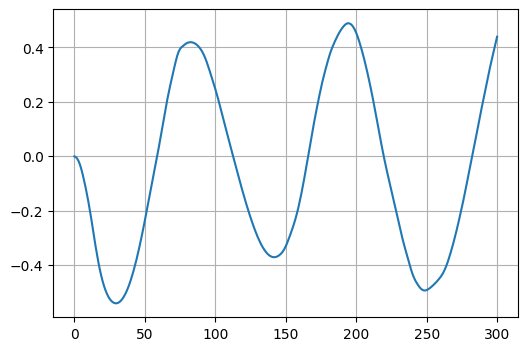

In [500]:
q = np.array([1.0, 0.0, 0.0, 0.0])
qwData = np.zeros((len(wData), 4))

for i in range(len(qwData)):
    wx, wy, wz = wData[i]
    omega = np.array([0.0, wx, wy, wz])
    q_dot = 0.5 * quatProduct(q, omega)
    q = q + q_dot * dt
    q = normalize(q)
    qwData[i] = q


plt.figure(figsize=(6, 4))
plt.plot([q1 for (q0, q1, q2, q3) in qwData])
plt.grid()

- Comparando os dois com saída normalizada (para ficarem na mesma escala)

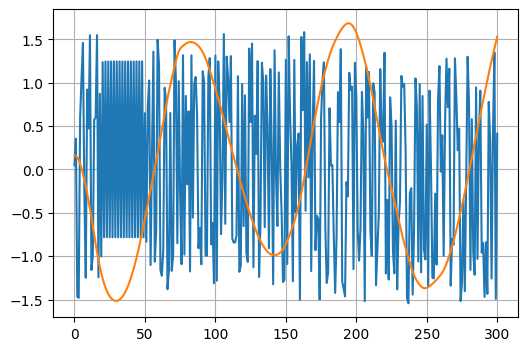

In [501]:
plt.figure(figsize=(6, 4))
plt.plot(norm([q1 for (q0, q1, q2, q3) in qaData]))
plt.plot(norm([q1 for (q0, q1, q2, q3) in qwData]))
plt.grid()

# ROW, PITCH, YAW

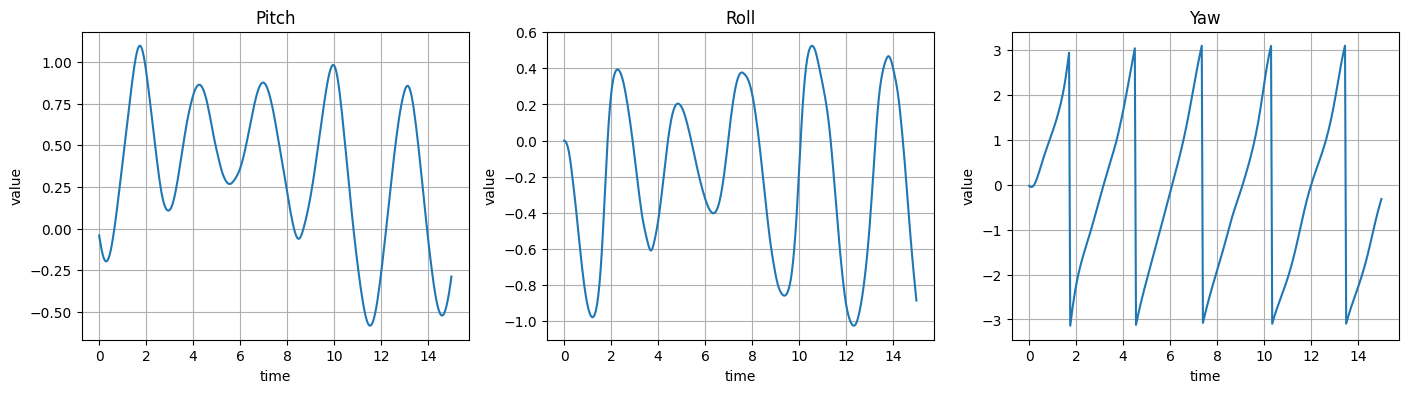

In [502]:
def getEuler(q0, q1, q2, q3):
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (q0 * q1 + q2 * q3)
    cosr_cosp = 1 - 2 * (q1**2 + q2**2)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pich (y-axis rotation)
    sinp  = 2*(q0 * q2 - q3 * q1)
    pitch = np.sign(sinp)*(np.pi/2) if abs(sinp) >= 1 else np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (q0 * q3 + q1 * q2)
    cosy_cosp = 1 - 2 * (q2**2 + q3**2)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return np.array([pitch, roll, yaw])


eulerData = np.array([getEuler(q0, q1, q2, q3) for q0, q1, q2, q3 in qwData])
plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(tData, [pitch for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Pitch')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(tData, [roll for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Roll')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(tData, [yaw for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Yaw')
plt.grid()